**Modified TextRank with GloVe**

In [8]:
import os
import re
import string
import nltk
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.metrics.pairwise import cosine_similarity

nltk.download('punkt') # one time execution for sentence tokenization
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
!pip install PyDrive

In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
download = drive.CreateFile({'id': 'drive-link-to-the-embedding-file'})
download.GetContentFile('glove.6B.50d.txt')

In [0]:
dim = 50     #dimension of the VxD matrix present in the pre-trained word_embedding file.
#The above dimension will changed according to the embedding file we import, here we use 50d.
glove_file = "glove.6B.50d.txt"

In [0]:
#loading the word embeddings file

def load_glove_model(glove_file):
    word_vectors = {}
    glove_data = open(glove_file,encoding='utf-8')
    for line in glove_data:
      values = line.split()
      word = values[0]  #since the first column of the matrix represents words
      vectors = np.asarray(values[1:],dtype='float32') #float32 can represent upto 7 decimal places
      word_vectors[word] = vectors #storing the 50-dimension vector representation of each word in a dictionary 
    glove_data.close()
    return word_vectors
 
word_vectors = load_glove_model(glove_file)

In [15]:
#Structure of the word_vectors dictionary-  { word1 : [50d word vector representing word1], word2: [50d word vector representing word1]..}
print("Number of words:" + str(len(word_vectors)))  #V
x = next(iter(word_vectors))
print("Dimensionality:" + str(len(word_vectors[x])))        #D   as in VxD matrix
print("The first record in the dictionary:\n")
print("KEY: " + str(x) )
print("VALUE: " + str(word_vectors[x]))

Number of words:400000
Dimensionality:50
The first record in the dictionary:

KEY: the
VALUE: [ 4.1800e-01  2.4968e-01 -4.1242e-01  1.2170e-01  3.4527e-01 -4.4457e-02
 -4.9688e-01 -1.7862e-01 -6.6023e-04 -6.5660e-01  2.7843e-01 -1.4767e-01
 -5.5677e-01  1.4658e-01 -9.5095e-03  1.1658e-02  1.0204e-01 -1.2792e-01
 -8.4430e-01 -1.2181e-01 -1.6801e-02 -3.3279e-01 -1.5520e-01 -2.3131e-01
 -1.9181e-01 -1.8823e+00 -7.6746e-01  9.9051e-02 -4.2125e-01 -1.9526e-01
  4.0071e+00 -1.8594e-01 -5.2287e-01 -3.1681e-01  5.9213e-04  7.4449e-03
  1.7778e-01 -1.5897e-01  1.2041e-02 -5.4223e-02 -2.9871e-01 -1.5749e-01
 -3.4758e-01 -4.5637e-02 -4.4251e-01  1.8785e-01  2.7849e-03 -1.8411e-01
 -1.1514e-01 -7.8581e-01]


In [16]:
#Uploading the input document that is to be summarized
from google.colab import files
uploaded = files.upload()

Saving CricketLong.txt to CricketLong.txt


In [18]:
#Reading the input document and storing the given passage as a string. This is the raw text that needs to be processed.

dataset = "CricketLong.txt"  #Four such files are tested

def load_dataset(dataset):
  file = open(dataset,'r',encoding='cp1252')
  text = file.read()  #contains the entire text as a string
  file.close()
  return text

text = load_dataset(dataset)
print("Raw Text:")
print(text)
original_sentences = sent_tokenize(text)

Raw Text:
Cricket grew out of the many stick-and-ball games played in England 500 years ago, under a variety of different rules. The word bat is an old English word that simply means stick or club. By the seventeenth century, cricket had evolved enough to be recognisable as a distinct game and it was popular enough for its fans to be fined for playing it on Sunday instead of going to church. Till the middle of the eighteenth century, bats were roughly the same shape as hockey sticks, curving outwards at the bottom. There was a simple reason for this: the ball was bowled underarm, along the ground and the curve at the end of the bat gave the batsman the best chance of making contact. How that early version of cricket played in village England grew into the modern game played in giant stadiums in great cities is a proper subject for history because one of the uses of history is to understand how the present was made. And sport is a large part of contemporary life: it is one way in which 

In [19]:
#PREPROCESSING

#Sentence boundary identification
#Sentence tokenization
#Word tokenization
#Remove words that have non-ascii characters as they don't have any weights in the model
#convert to lower case
#Stop-word elimination
#Punctuation removal. Hyphen must be retained
#Join the new set of preocessed words for every sentence to form the set of preocessed sentences

def only_ascii(word):
  for ch in word:
    if ord(ch)>127:
      return False
  return True


def preprocessing(text):
  total_stopwords = set(stopwords.words('english'))
  #stopwords_list = total_stopwords - excluded_stopwords
  punctuation = string.punctuation
  processed_sentences = []

  sentences = sent_tokenize(text)
  for sentence in sentences:
    word_list = ""
    words = word_tokenize(sentence)
    for word in words:
      if(only_ascii(word)):
        if word.lower() not in total_stopwords and word not in punctuation:
          word_list = word_list + word.lower() + " "
    
    processed_sentences.append(word_list)   
  return processed_sentences 

processed_sentences = preprocessing(text)
print("Length of the input document:" + str(len(processed_sentences)) + " sentences")


Length of the input document:68 sentences


In [20]:
#Obtaining  sentence vectors using word vectors derived from the GloVe word embedding
def vectorize_sentences(processed_sentences):
  sentence_vectors = []
  for sentence in processed_sentences:
    no_of_words = len(sentence)
    if no_of_words != 0:      #making sure the sentence is not empty
      word_sum = sum([word_vectors.get(word, np.zeros(dim,)) for word in sentence.split()]) #if the word exists in the keys (in glove file), vector is obtained, else zeros matrix is created
      vec = word_sum/(no_of_words +0.001)
    else:
      vec = np.zeros((dim,))
    sentence_vectors.append(vec)
  return sentence_vectors

sentence_vectors = vectorize_sentences(processed_sentences)
print("Sample: First Sentence Vector :\n")
print(sentence_vectors[0])


Sample: First Sentence Vector :

[-2.92913117e-02  2.14646901e-02 -4.66870797e-02  1.73282878e-03
 -5.39287635e-03  2.12612250e-02 -1.01282486e-01 -3.91215215e-02
 -3.71279661e-02 -1.28693163e-02 -1.71674015e-03 -3.73412189e-03
 -5.04120165e-02 -4.66321999e-02  9.11787817e-02  1.29024837e-05
  1.82212265e-02  2.57791539e-02 -1.02159748e-01 -4.18784251e-02
  5.82982462e-04  2.18965662e-02  4.81653356e-02  3.04861024e-02
 -3.21213180e-03 -1.38664471e-01 -1.98069360e-02 -4.36180425e-02
 -1.05969397e-02 -2.17685153e-03  4.06182549e-01  4.47595010e-02
  3.11084243e-02 -4.82900174e-02  5.34913858e-02  1.77238947e-02
  7.44583135e-03  3.88729137e-02 -4.82829860e-02 -2.97350037e-02
 -5.76093849e-02 -7.38383303e-03  1.94587132e-02  5.81539324e-02
 -1.17436004e-02  5.91280109e-02 -3.78069686e-02 -7.98931464e-03
 -3.52623248e-02 -2.65830703e-02]


In [21]:
#Forming Cosine Similarity Matrix
def get_similarity_matrix(processed_sentences):
  sent_count = len(processed_sentences)
  sim_mat = np.zeros([sent_count, sent_count])  #creating a symmetric zeros matrix
  for i in range(sent_count):
      for j in range(sent_count):
          if i != j:
            #cosine_similarity() takes two matrices,so reshaping list items to 1D vectors. The resulting matrix is of 1x1. Storing that value in i,j position of sim_mat 
            sim_mat[i][j] = cosine_similarity(sentence_vectors[i].reshape(1,dim),sentence_vectors[j].reshape(1,dim))[0,0]
  sim_mat = np.round(sim_mat,4) #rounding off upto three decimal places
  return sim_mat

sim_mat = get_similarity_matrix(processed_sentences)
print(sim_mat)

[[0.     0.7974 0.9332 ... 0.7377 0.8096 0.7775]
 [0.7974 0.     0.8904 ... 0.6762 0.7401 0.7575]
 [0.9332 0.8904 0.     ... 0.7132 0.8056 0.7958]
 ...
 [0.7377 0.6762 0.7132 ... 0.     0.5324 0.5827]
 [0.8096 0.7401 0.8056 ... 0.5324 0.     0.8711]
 [0.7775 0.7575 0.7958 ... 0.5827 0.8711 0.    ]]


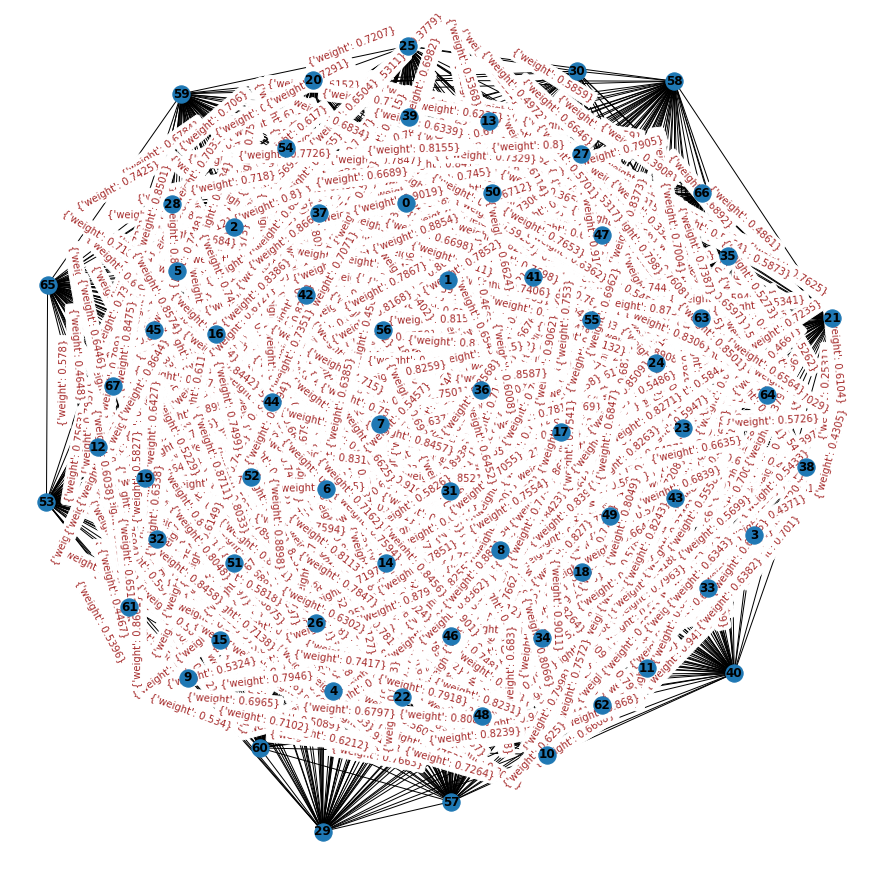

In [22]:
def network_scores(sim_mat):
  nx_graph = nx.from_numpy_array(sim_mat)
  plt.figure(figsize=(12, 12))
  pos = nx.spring_layout(nx_graph)
  nx.draw(nx_graph, with_labels=True, font_weight='bold')
  nx.draw_networkx_edge_labels(nx_graph,pos,font_color='brown')
  scores = nx.pagerank(nx_graph)
  plt.savefig("MTR_Glove_Graph.png")
  files.download("MTR_Glove_Graph.png")
  plt.show()
  return scores


scores = network_scores(sim_mat)

In [24]:
print(scores)
print(type(scores))
ranked_sentences = sorted(((scores[i],i) for i,s in enumerate(original_sentences)), reverse=True)
print(ranked_sentences)
arranged_sentences = sorted(ranked_sentences[0:int(len(original_sentences)*0.25)], key=lambda x:x[1])


{0: 0.01579334681029023, 1: 0.015047333963805082, 2: 0.015972209103521387, 3: 0.013987072097265235, 4: 0.015431354591019766, 5: 0.016065113719311564, 6: 0.014993661261387185, 7: 0.015796739728070816, 8: 0.014268383817814331, 9: 0.01561418142304813, 10: 0.015414551110705004, 11: 0.015467016234145644, 12: 0.015428272427706245, 13: 0.0160591328648961, 14: 0.015963027750992873, 15: 0.01519115491238196, 16: 0.015939301432679968, 17: 0.01544859223960449, 18: 0.014415510246815508, 19: 0.013260804456235124, 20: 0.014388038228911992, 21: 0.011810936221059613, 22: 0.015733660967926315, 23: 0.014567969778204543, 24: 0.013539259220604196, 25: 0.013783606110974686, 26: 0.014087721787007835, 27: 0.014020815422142967, 28: 0.01533330893539269, 29: 0.011463790341271023, 30: 0.01304992068299103, 31: 0.015093385612449649, 32: 0.015293786289030598, 33: 0.0150009303335323, 34: 0.015431325719173659, 35: 0.014677409827454144, 36: 0.015656069112348042, 37: 0.014323343151671995, 38: 0.013673643037901102, 39: 0

In [25]:
print("***SUMMARY***\n\n")
summary = "\n".join([original_sentences[x[1]] for x in arranged_sentences])
print(summary)

***SUMMARY***


Cricket grew out of the many stick-and-ball games played in England 500 years ago, under a variety of different rules.
By the seventeenth century, cricket had evolved enough to be recognisable as a distinct game and it was popular enough for its fans to be fined for playing it on Sunday instead of going to church.
How that early version of cricket played in village England grew into the modern game played in giant stadiums in great cities is a proper subject for history because one of the uses of history is to understand how the present was made.
If tens of millions of Indians today drop everything to watch the Indian team play a Test match or a one-day international, it is reasonable for a history of India to explore how that stick-and-ball game invented in south-eastern England became the ruling passion of the Indian sub-continent.
Our history of cricket will look first at the evolution of cricket as a game in England, and discuss the wider culture of physical trainin

In [0]:
#writing the summary into a text file
from google.colab import files

filename = "Modified_TR_Glove_Summary.txt"

with open(filename,"w") as f:
  f.write(summary)

files.download(filename)